# RAG Agent (LangGraph + LangChain + Chroma)

This notebook ingests documents from `data/`, builds a Chroma vector DB with local embeddings, and wires a simple LangGraph RAG agent you can run locally.

## 0. Setup
Create and activate a virtual environment, then install requirements:

```bash
pip install -r requirements.txt
```

In [6]:
# Imports & logging
import os, logging
from rich.logging import RichHandler

logging.basicConfig(level=logging.INFO, format="%(message)s", handlers=[RichHandler(rich_tracebacks=True)])
log = logging.getLogger("nb")

In [14]:
# Config
DATA_DIR = r"C:\Users\sangi\Downloads\Medical"
DB_DIR = "chroma_db"
EMBED_MODEL_NAME = "all-MiniLM-L6-v2"  # SentenceTransformers model (no API key needed)


In [16]:
# LangChain / LangGraph / Chroma imports
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader, TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_core.documents import Document

from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from typing import List, Dict, Any

In [22]:
# 1) Load documents
from pathlib import Path

def load_documents(data_dir: str) -> List[Document]:
    docs: List[Document] = []
    p = Path(data_dir)
    assert p.exists(), f"{data_dir} not found — create it and add PDFs or text files."
    for fname in os.listdir(data_dir):
        fp = p / fname
        if fname.lower().endswith(".pdf"):
            docs.extend(PyPDFLoader(str(fp)).load())
        elif fname.lower().endswith((".txt", ".md")):
            docs.extend(TextLoader(str(fp), encoding="utf-8").load())
    return docs

docs = load_documents(DATA_DIR)
len(docs)

642

In [20]:
!pip install pypdf

In [24]:
# 2) Split & embed, then build (or refresh) Chroma vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=120, separators=["\n\n", "\n", " ", ""])
splits = splitter.split_documents(docs)
embedder = SentenceTransformerEmbeddings(model_name=EMBED_MODEL_NAME)

# Fresh build
vs = Chroma.from_documents(splits, embedder, persist_directory=DB_DIR)
vs.persist()
len(splits)

C:\Users\sangi\AppData\Local\Temp\ipykernel_23176\1442801060.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = SentenceTransformerEmbeddings(model_name=EMBED_MODEL_NAME)


[11/12/25 13:44:50] INFO     Use pytorch device_name: cpu                                ]8;id=9604;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py\SentenceTransformer.py]8;;\:]8;id=494192;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py#219\219]8;;\

                    INFO     Load pretrained SentenceTransformer: all-MiniLM-L6-v2       ]8;id=846817;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py\SentenceTransformer.py]8;;\:]8;id=767862;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py#227\227]8;;\

[11/12/25 13:44:55] INFO     Anonymized telemetry enabled. See                                        ]8;id=284460;file://C:\Users\sangi\anaconda3\Lib\site-packages\chromadb\telemetry\product\posthog.py\posthog.py]8;;\:]8;id=271605;file://C:\Users\sangi\anaconda3\Lib\site-packages\chromadb\telemetry\product\posthog.py#22\22]8;;\
                             https://docs.trychroma.com/telemetry for more information.                            

C:\Users\sangi\AppData\Local\Temp\ipykernel_23176\1442801060.py:8: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vs.persist()


3641

In [26]:
# 3) Define graph state and nodes
class AgentState(BaseModel):
    messages: List[Dict[str, Any]] = Field(default_factory=list)
    context: List[str] = Field(default_factory=list)

def retrieve_node(state: AgentState) -> AgentState:
    question = ""
    for m in reversed(state.messages):
        if m.get("role") == "user":
            question = m.get("content", "")
            break
    if not question:
        return state

    client = SentenceTransformerEmbeddings(model_name=EMBED_MODEL_NAME)
    vs = Chroma(persist_directory=DB_DIR, embedding_function=client)
    retrieved = vs.similarity_search(question, k=5)
    ctx = [f"[{i+1}] {d.page_content}" for i, d in enumerate(retrieved)]
    state.context = ctx
    return state

def answer_node(state: AgentState) -> AgentState:
    question = ""
    for m in reversed(state.messages):
        if m.get("role") == "user":
            question = m.get("content", "")
            break

    if not state.context:
        answer = "I couldn't find relevant context. Try rephrasing or adding more documents."
    else:
        summary = "\n\n".join(state.context)
        answer = f"Q: {question}\n\nTop context:\n{summary}\n\nDraft answer (summarize and cite the numbered chunks above)."

    state.messages.append({ "role": "assistant", "content": answer })
    return state

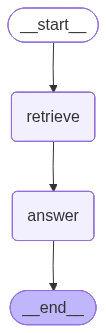

In [28]:
# 4) Wire the graph
graph = StateGraph(AgentState)
graph.add_node("retrieve", retrieve_node)
graph.add_node("answer", answer_node)
graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "answer")
graph.add_edge("answer", END)

app = graph.compile()
app

In [40]:
# 5) Run a sample query
state = AgentState(messages=[{"role": "user", "content": "What are the main requirements of the interview task?"}])
out = app.invoke(state)
out

[11/12/25 14:00:49] INFO     Use pytorch device_name: cpu                                ]8;id=14165;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py\SentenceTransformer.py]8;;\:]8;id=56013;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py#219\219]8;;\

                    INFO     Load pretrained SentenceTransformer: all-MiniLM-L6-v2       ]8;id=29297;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py\SentenceTransformer.py]8;;\:]8;id=204120;file://C:\Users\sangi\anaconda3\Lib\site-packages\sentence_transformers\SentenceTransformer.py#227\227]8;;\

{'messages': [{'role': 'user',
   'content': 'What are the main requirements of the interview task?'},
  {'role': 'assistant',
   'content': "Q: What are the main requirements of the interview task?\n\nTop context:\n[1] # Interview Task — Extracted Requirements\n\nBelow is an automatic extraction of the task requirements from the provided PDF. Review and edit as needed.\n\n## Heuristic Requirements Summary\nTask Requirements (heuristic extraction)\n\n- \n\n---\n\n## Full Extracted Text (for reference)\n> This section includes the raw text extracted from the PDF so you can refine the final requirements manually if needed.\n\n```\ntext_extraction_log=['Extracted text with PyPDF2.']\n\n\n===== PAGE 1 =====\n \n \n \n\n \n\n \n\n\n \n\n \n\n\n\n\n \n \n\n \n \n \n\n \n \n \n \n\n \n\n\n \n1.\n \n \n\n\n\n\n \n2.\n \n\n\n \n \n\n\n\n \n3.\n \n\n\n\n\n \n \n4.\n \n\n\n\n\n \n \n\n\n \n\n \n \n\n\n \n\n \n\n\n\n \n\n \n\n\n\n \n \n\n \n\n\n\n \n \n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n \n\n \n\n\n\n